Import the necessary modules

In [311]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# import requests
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import fredapi as fa
from local_settings import fred as settings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

In [312]:
#import the API key
fred = fa.Fred(settings['API_KEY'])

In [313]:
#retrieve the data using the get_series() method and convert it to a dataframe
df = fred.get_series('RSXFS').to_frame(name='RSXFS').reset_index()
df.head()

,index,RSXFS
0,1992-01-01,142419.0
1,1992-02-01,142584.0
2,1992-03-01,142120.0
3,1992-04-01,143659.0
4,1992-05-01,144239.0


In [314]:
#to rename the index column to date
df = df.rename(columns={'index':'date'})
df.head() 

,date,RSXFS
0,1992-01-01,142419.0
1,1992-02-01,142584.0
2,1992-03-01,142120.0
3,1992-04-01,143659.0
4,1992-05-01,144239.0


Data Preprocessing

In [315]:
#check for missing values - conlusion: there are no missing values in our data 
df.isnull().sum()

date     0
RSXFS    0
dtype: int64

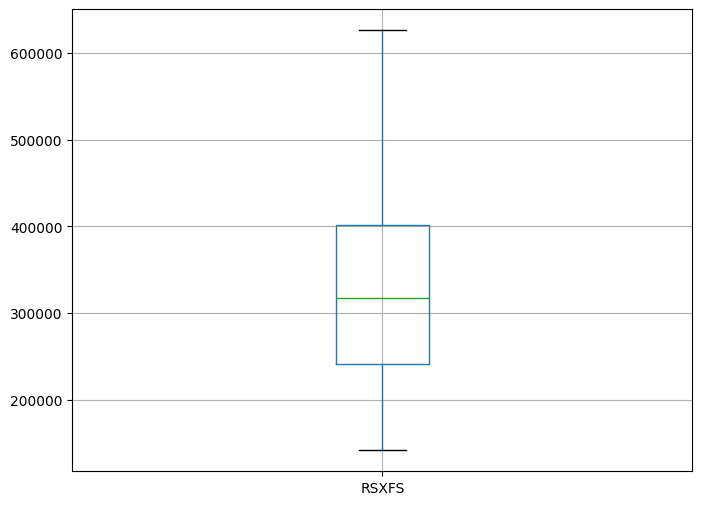

In [316]:
#to visualize outliers using a boxplot - conclusion: there are no outliers in the data
plt.figure(figsize=(8,6))
df.boxplot() 
plt.show()

In [317]:
#to check for duplicates in the index column - conclusion: no duplicates in the index column
df['date'].duplicated().sum()

0

In [318]:
#to check for duplicates in the RSXFS column - conclusion: no duplicates in the RSXFS column
df['RSXFS'].duplicated().sum()

0

In [319]:
#to get the datatypes for our columns - our date column is already converted to a datetime object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    400 non-null    datetime64[ns]
 1   RSXFS   400 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.4 KB


In [320]:
#set the date column as the index of the dataframe to enable resampling and rolling operations (moving statistics like averages, sums) for a sliding time window
df.set_index('date', inplace=True)
df.head()

,RSXFS
date,
1992-01-01,142419.0
1992-02-01,142584.0
1992-03-01,142120.0
1992-04-01,143659.0
1992-05-01,144239.0


In [321]:
#perform upsampling by breaking the monthly date column to bi-weekly to get the retail sales made every two weeks from the sector. 

#using a frequency that ensures exact splits between the monthly entries
df = df.asfreq('MS')

#to anchor the dates since biweekly may interpolate between the start of months
df_biweekly = df.resample('2W-SUN').asfreq()

#use interpolation to fill in the missing values
df_biweekly = df_biweekly.interpolate(method='time')
df_biweekly.head()

,RSXFS
date,
1992-01-05,NaN
1992-01-19,NaN
1992-02-02,NaN
1992-02-16,NaN
1992-03-01,142120.0


In [322]:
#to check for missing values in the data 
df_biweekly.isnull().sum() 

RSXFS    4
dtype: int64

In [323]:
#drop the missing values
df_biweekly.dropna(inplace=True)

In [324]:
#visualize our dataset with plotly for interactivity 

#create a subplot of 1 row, 2 columns
fig = make_subplots(rows = 1, cols = 2, subplot_titles = ('Before Upsampling', 'After Upsampling'))

# a) plot for before upsampling 

fig.add_trace(
    go.Scatter(
        x = df.index,
        y = df[df.columns[0]],
        mode = 'lines',
        line = dict(color = 'steelblue')
    ),
    row = 1, col = 1
)

# b) plot after upsampling

fig.add_trace(
    go.Scatter(
        x = df_biweekly.index,
        y = df_biweekly[df_biweekly.columns[0]],
        mode = 'lines',
        line = dict(color = 'red')
    ),
    row = 1, col = 2
)

fig.update_layout(
    width = 1000,
    height = 600,
    xaxis_title = 'Date',
    yaxis_title = 'Retail Sales in Millions (USD)',
    title_text = 'Retail Sales Comparison: Before and After Upsampling',
    showlegend = False
)

fig.update_xaxes(title_text = 'Date', row = 1, col = 1)
fig.update_yaxes(title_text = 'Retail Sales in Millions (USD)', row = 1, col = 1)

fig.update_xaxes(title_text = 'Date', row = 1, col = 2)
fig.update_yaxes(title_text = 'Retail Sales in Millions (USD)', row = 1, col = 2)

fig.show()

Conclusion: 

- From the above graphs, our series doesn't satisfy the required stationarity assumption of time series just yet. It shows an exponential trend whereby the mean is a function of time.

- Why an exponential trend? The assumption is that as the Retail and Food Services sector continued growing in the United States, the overall sales also grew with each month since it got more popular across its growing population over the years.  

To prove there is a trend in our data using rolling statistics (using our df_biweekly (upsampled) data)):

In [325]:
roll_mean = df_biweekly.rolling(window = 4, center = False).mean() 
roll_std = df_biweekly.rolling(window = 4, center = False).std()

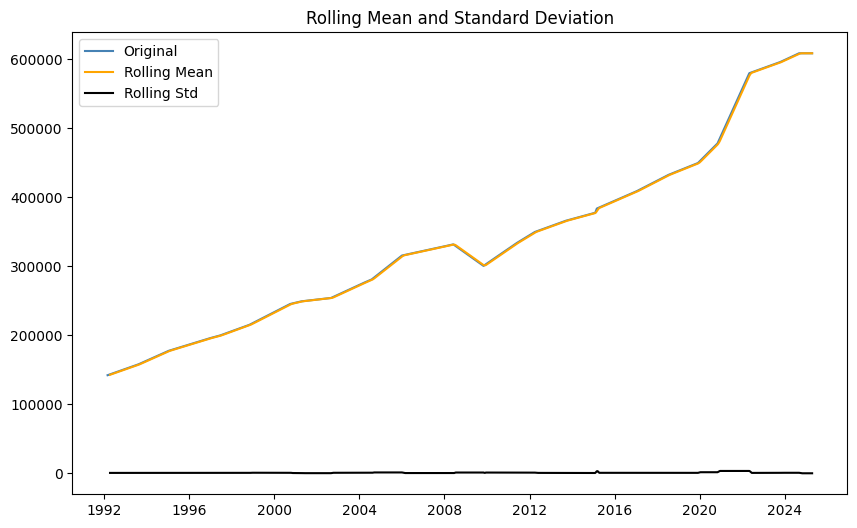

In [326]:
#to plot the rolling mean and standard deviation
plt.figure(figsize=(10,6))
plt.plot(df_biweekly, color = 'steelblue', label = 'Original')
plt.plot(roll_mean, color = 'orange', label = 'Rolling Mean')
plt.plot(roll_std, color = 'black', label = 'Rolling Std')
plt.title('Rolling Mean and Standard Deviation')
plt.legend(loc='best')
plt.show()

Conclusion: 

- The orange line represents the rolling mean while the black line represents the rolling standard deviation. 

- The mean is not constant over time, meaning we can reaffirm our conclusion that the time series is not stationary based on the two statistics.  

Implementing the Dickey-Fuller test to prove that our data does indeed have a trend:

In [327]:
#our null hypothesis is that the time series data is not stationary
df_test = adfuller(df_biweekly)

#to extract and display the results in a human-readable format
df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value','#Lags Used', 'Number of Observations Used'])


for key, value in df_test[4].items():
    df_output['Critical Value (%s)'%key] = value

print(df_test, '\n')

print('Output of the Dickey-Fuller test:\n')

print(df_output)

(0.16571809017588782, 0.9702719351220528, 3, 861, {'1%': -3.4379677736185514, '5%': -2.8649026847264074, '10%': -2.568560548763626}, 11064.516871794585) 

Output of the Dickey-Fuller test:

Test Statistic                   0.165718
p-value                          0.970272
#Lags Used                       3.000000
Number of Observations Used    861.000000
Critical Value (1%)             -3.437968
Critical Value (5%)             -2.864903
Critical Value (10%)            -2.568561
dtype: float64


Conclusion: 

- Since our test statistic is greater than the critical value at 1, 5 and 10%, we fail to reject the null hypothesis and conclude that our time series is indeed not stationary.

Removing the trend using the Differencing technique. 

- Why use Differencing? It's one of the most common methods of dealing with both trend and seasonality in time series data.

- It works really well with removing linear trend (which is represented using the rolling mean) and helps in improving stationarity.

- Here, we take the difference between an observation at a particular time instance and that at a previous time instant (1-period lag).

In [328]:
diff_data = df_biweekly.diff(periods=1)
diff_data.head()

,RSXFS
date,
1992-03-01,NaN
1992-03-15,413.648649
1992-03-29,413.648649
1992-04-12,413.648649
1992-04-26,413.648649


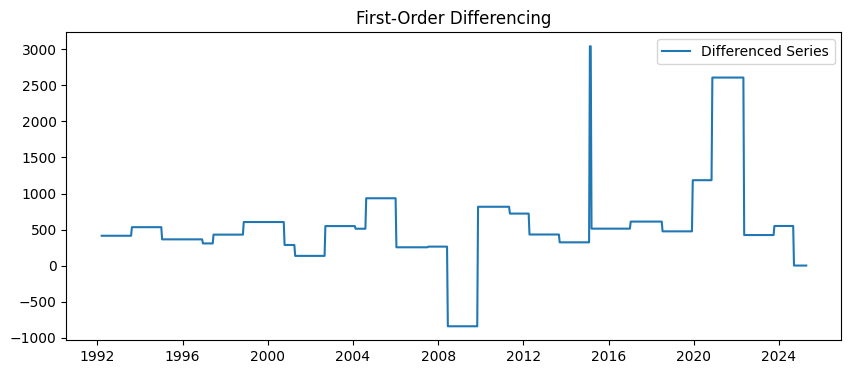

In [329]:
#to visualize the series after performing differencing
plt.figure(figsize=(10,4))
plt.plot(diff_data, label = "Differenced Series")
plt.title("First-Order Differencing")
plt.legend()
plt.show()

In [330]:
#drop the missing value 
diff_data.dropna(inplace=True)

In [331]:
#verify there are no missing values in the data
diff_data.isnull().sum()

RSXFS    0
dtype: int64

<Axes: >

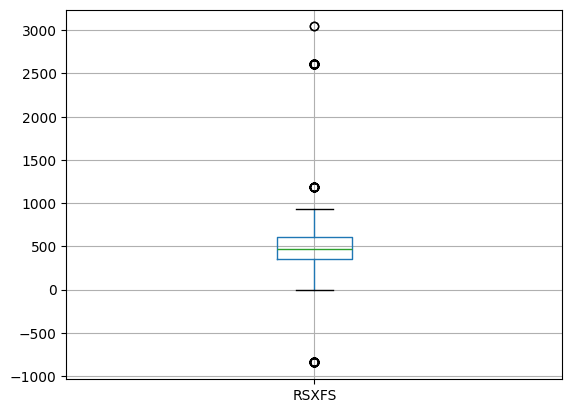

In [332]:
#check for outliers after performing differencing using a boxplot 
diff_data.boxplot()

- The circles represent the presence of outliers.

- Using the interquartile range method to remove outliers after differencing

In [ ]:
#define the outlier threshold using IQR
Q1 = diff_data.quantile(0.25)
Q3 = diff_data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#mask values outside the IQR bounds with NAN 
diff_data_no_outliers = diff_data.mask((diff_data < lower_bound) | (diff_data > upper_bound))

In [334]:
#impute missing values present in the data after removing outliers to maintain continuity
diff_data_imputed = diff_data_no_outliers.interpolate(method='time').ffill().bfill()

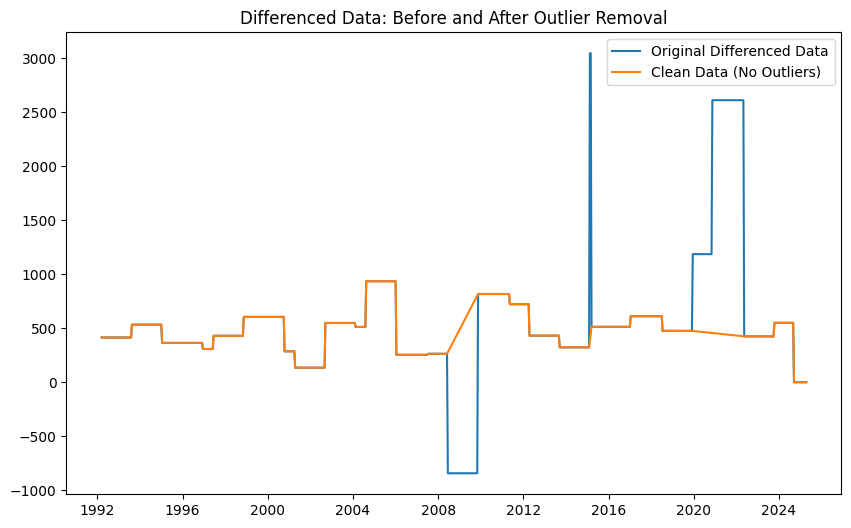

In [335]:
#visualize the data before and after handling outliers 
plt.figure(figsize=(10,6))
plt.plot(diff_data, label = 'Original Differenced Data')
plt.plot(diff_data_imputed, label = 'Clean Data (No Outliers)')
plt.legend(loc = 'best')
plt.title('Differenced Data: Before and After Outlier Removal')
plt.show(block=False)

Conclusion:

- After removing outliers in our differenced data, the orange line shows that our series shows some kind of stationarity. We can confirm this by performing a Dickey-Fuller Test as follows:

In [336]:
diff_data_test = adfuller(diff_data_imputed)

diff_data_output = pd.Series(diff_data_test[0:4], index = ['Test Statistic','p-value','#Lags Used', 'Number of Observations Used'])

for key, value in diff_data_test[4].items():
    diff_data_output['Critical Value (%s)'%key] = value

print(diff_data_test, '\n')

print('Output of the Dickey-Fuller Test after Differencing \n')

print(diff_data_output)

(-2.7914840721114715, 0.059500541890157084, 0, 863, {'1%': -3.4379500665211276, '5%': -2.864894878219008, '10%': -2.5685563904109867}, 8688.885539626763) 

Output of the Dickey-Fuller Test after Differencing 

Test Statistic                  -2.791484
p-value                          0.059501
#Lags Used                       0.000000
Number of Observations Used    863.000000
Critical Value (1%)             -3.437950
Critical Value (5%)             -2.864895
Critical Value (10%)            -2.568556
dtype: float64


Interpretation: 

- The null hypothesis is that the time series data is not stationary. 

- The test statistic (-2.791) is less than the critical value at 10% (-2.569), therefore, we reject the null hypothesis and conclude that the series is likely stationary after performing differencing.

- We can now conclude that the statistical properties, i.e. mean, variance and covariance are constant over time but at 10% significance level.

To observe seasonality using decomposition. Time series decomposition splits the series into three component series namely:

- Seasonal: Patterns that repeat within a fixed period.

- Trend: The underlying trend of the metric.

- Random (noise, irregular or remainder): The residual of the original time series after the seasonal and trend series are removed.  

In [ ]:
# series = diff_data_imputed.copy()
# series = series[series.columns[0]]

In [339]:
series = diff_data_imputed['RSXFS']

print(type(series))

<class 'pandas.core.series.Series'>


In [341]:
#handle negative or zero values before logging and convert them to positive values
if(series <=0).any():
    series = series + abs(series.min()) + 1

#transform the series 
series = np.log(series)

#remove any NaNs or Infs
series = series.replace([np.inf, -np.inf], np.nan).dropna()

#to verify that there are no missing values in the series
print(series.isna().sum(), '\n')

print(np.isinf(series).sum())

0 

0


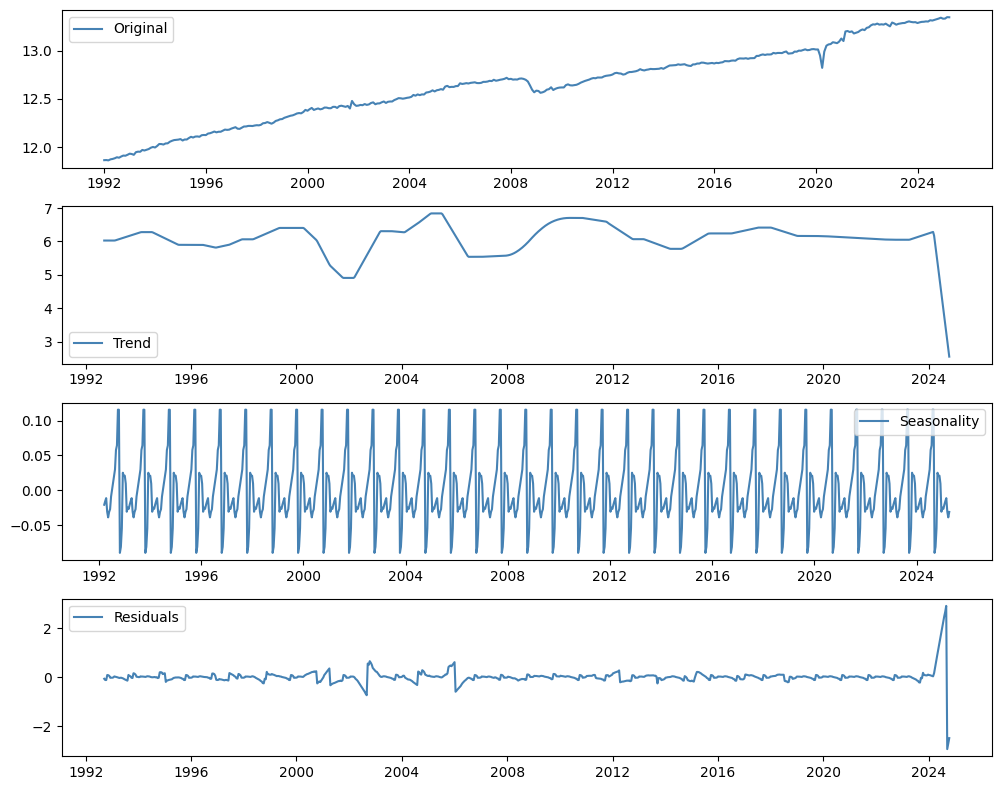

In [ ]:
decomposition = seasonal_decompose(series, model='additive', period=26)

#get the trend, seasonality and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#plot the components
plt.figure(figsize=(10,8))

plt.subplot(411)
plt.plot(np.log(df), label = 'Original', color = 'steelblue')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'steelblue')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', color = 'steelblue')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals', color = 'steelblue')
plt.legend(loc = 'best')

plt.tight_layout()


To check for Autocorrelation using the Autocorrelation Function (Plot):

- Checks how each time series observation is related to it past or recent past. 

- The dotted lines imply the statistical significance of the correlation. 

- In this case, most spikes fall within the confidence bounds (dotted lines). 

- Since no large spikes are above or below the confidence bounds, that means there is no significant autocorrelation left, as well as no trend or seasonality in the series.

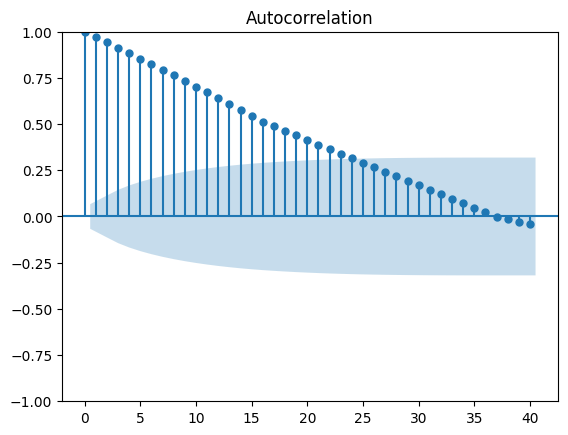

In [ ]:
# plt.figure(figsize=(10,4))
# pd.plotting.autocorrelation_plot(diff_data_imputed);
plot_acf(diff_data_imputed, lags=40);
plt.show()

Modeling using ARMA (2,1). I am buliding a model where:

- The AR (autoregressive part) has an order of 2.

- The MA (moving average part) has an order of 1. 

- Therefore, it's a second-order AR model combined with a first-order MA model.

- Why ARIMA? Since my data is time-dependent (sales are recorded over time), ARIMA has the capability to exploit patterns over time. 

- ARIMA is also designed for forecasting, meaning it will be ideal for predicting future sales based on past trends. 

- ARIMA captures both long-term and short-term irregularities since retail sales either trend upward or downward over time or fluctuate due to external shocks like holidays, inflation, or pandemics. 

- My data is univariate (it only has a single variable over time, i.e. retail sales) and ARIMA is best suited for univariate time series. 

In [ ]:
#split the data into train and test sets using the date, i.e. 1st January 2020
split_date = '2020-01-01'

#the data before 1st January 2020 will be used for training
train = diff_data_imputed.loc[diff_data_imputed.index < split_date] 

#the data from 1st January 2020 onwards will be used for testing
test = diff_data_imputed.loc[diff_data_imputed.index >= split_date] 

In [ ]:
print(type(train))
print(type(test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
#convert the train and test data into a series since ARIMA requires data in a series format, not dataframe
train_series = train['RSXFS']
test_series = test['RSXFS']

In [ ]:
print(type(train_series))
print(type(test_series))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
from pmdarima import auto_arima

model = auto_arima(
    train_series,
    start_p = 0, max_p = 5,
    start_q = 0, max_q = 5,
    d = None,
    seasonal = False,
    stepwise = True,
    trace = True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7424.805, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7426.676, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7426.678, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7422.808, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7428.327, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.846 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  726
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3710.404
Date:                Wed, 21 May 2025   AIC                           7422.808
Time:                        14:23:33   BIC                           7427.394
Sample:                    03-15-1992   HQIC                          7424.578
                         - 12-29-2019                                       

In [ ]:
# model = ARIMA(train_series, order=(2,0,1))
# result = model.fit()
# print(result.summary())

In [ ]:
print(model.params)

<bound method ARIMA.params of ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>


Forecast and evaluate on the test series

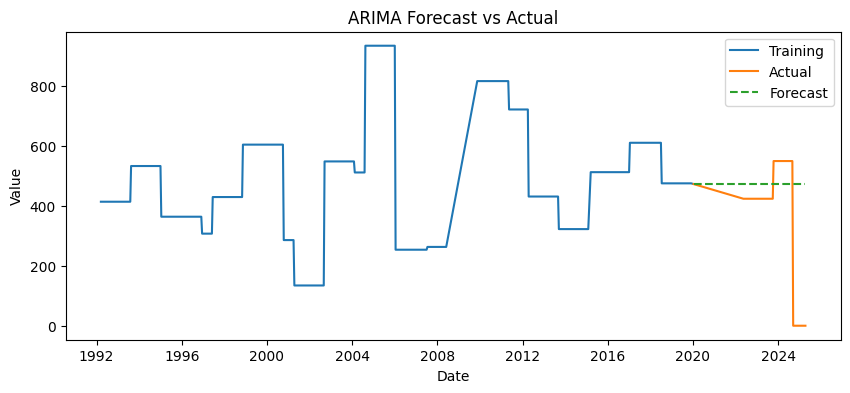

In [ ]:
#using the trained ARIMA model to predict the same number of steps as the test set
forecast = model.predict(n_periods=len(test_series))

plt.figure(figsize=(10,4))
plt.plot(train_series.index, train_series, label = 'Training')
plt.plot(test_series.index, test_series, label = 'Actual')
plt.plot(test_series.index, forecast, label = 'Forecast', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

Using evaluation metrics (mean absolute error and mean squared error) to test the performance of my model:

In [ ]:
mae = mean_absolute_error(test_series, forecast)
mse = mean_squared_error(test_series, forecast)
rmse =np.sqrt(mse)

In [ ]:
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 92.43
Root Mean Squared Error: 167.35


Interpretation of the error metrics:

- Using the mean abslolute error, the model forecasting is off by USD 45 million on average. 

- Using Mean Absolute Percentage Error to explain by what percentage my model performance is off by:

In [ ]:
mape = mean_absolute_percentage_error(test_series, forecast)
print(f'MAPE: {mape:.2f}%')

MAPE: 247158182605254464.00%


- This implies that my model performance is off by 0.1%. Since the relative error is less than 10%, this means that the model has an excellent forcasting acuracy.

- The model is making errors that are less than 1% of the actua sales values on average.

Residual Analysis to assess the quality of the model's prediction 

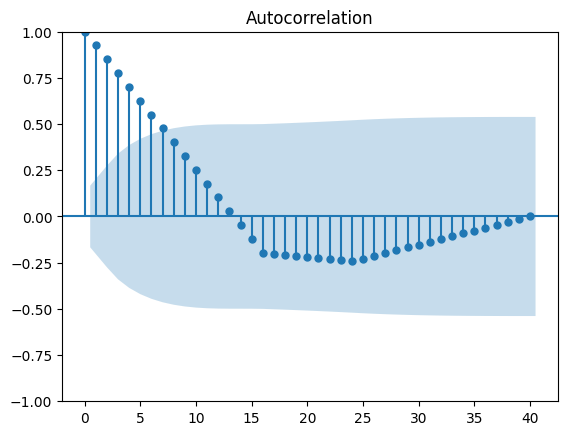

In [ ]:
#calculate the residuals
residuals = test_series - forecast

#plot the ACF of residuals
plot_acf(residuals, lags=40)
plt.show()

Interpretation: 

- Since most lags fall within the blue bounds, this implies that the residuals are uncorrelated, meaning that the model has managed to capture trend and seasonality in the data, hence performing well.

<!-- Modeling -->